# Coco Dataset Investigation

In [4]:
import json
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from transformers.tokenization_bert import BasicTokenizer
import nltk
import torch
from pycocotools.coco import COCO
import spacy 

In [6]:
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.modeling.language_backbone.transformers import BERT

In [7]:
nlp = spacy.load("en_core_web_sm")

In [8]:
ann_file = '../datasets/coco/annotations/captions_train2017.json'
with open(ann_file, 'r') as fin:
    coco_train_anno_all = json.load(fin)

In [9]:
len(coco_train_anno_all['annotations'])

591753

In [10]:
print(coco_train_anno_all['annotations'][0])

{'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}


In [11]:
count=1
id=coco_train_anno_all['annotations'][0]['image_id']
for item in coco_train_anno_all['annotations'][1:]:
    if item['image_id'] == id:
        count += 1
print(count)

5


In [12]:
tokenizer = BasicTokenizer(do_lower_case=True)

In [42]:
nltk.pos_tag(tokenizer.tokenize("He takes a banana."))

[('he', 'PRP'), ('takes', 'VBZ'), ('a', 'DT'), ('banana', 'NN'), ('.', '.')]

# Getting Stats

In [14]:
# Counts number of examples for each noun 
# for those sentences having number of noun types each of {0,1,2,..max_noun_no,'Rest'}

def per_tp_no_distr_stats(max_noun_no, tp):
    
    noun_distr_per_noun_no = {}
    ex_count_per_noun_no = {}
    img_caps_per_noun_no = {}
    img_nouns_per_noun_no = {}
    
    for i in range(1,max_noun_no+1):
        noun_distr_per_noun_no[i] = {}
        ex_count_per_noun_no[i] = 0 
        img_caps_per_noun_no[i] = []
        img_nouns_per_noun_no[i] = []
        
    noun_distr_per_noun_no['Rest'] = {}
    ex_count_per_noun_no['Rest'] = 0 
    img_caps_per_noun_no['Rest'] = []
    img_nouns_per_noun_no['Rest'] = []
    
    ex_count_per_noun_no[0] = 0 
    img_caps_per_noun_no[0] = []
    img_nouns_per_noun_no[0] = []
    
    net_unique_nouns = set()
    
    def put_words_in_dict(d, ws):
        for w in ws:
            if w not in d:
                d[w] = 1
            else:
                d[w] += 1
    
    for item in coco_train_anno_all['annotations']:
        text = item['caption']
        noun_types_per_ex = set()
        noun_str = ''
        
        for tok in nlp(text):
            if tp in tok.tag_:
                noun_types_per_ex.add(str(tok))
                
        no_noun_types_per_ex = len(noun_types_per_ex)
        noun_str = ' '.join(list(noun_types_per_ex))
        
        if no_noun_types_per_ex == 0:
            ex_count_per_noun_no[0] += 1
            img_caps_per_noun_no[0].append((item['image_id'], item['id']))
            img_nouns_per_noun_no[0].append((item['image_id'], noun_str))
            continue
        
        elif no_noun_types_per_ex <= max_noun_no:
            d_to_fill = noun_distr_per_noun_no[no_noun_types_per_ex]
            ex_count_per_noun_no[no_noun_types_per_ex] += 1
            img_caps_per_noun_no[no_noun_types_per_ex].append((item['image_id'], item['id']))
            img_nouns_per_noun_no[no_noun_types_per_ex].append((item['image_id'], noun_str))
            
        else:
            d_to_fill = noun_distr_per_noun_no['Rest']
            ex_count_per_noun_no['Rest'] += 1
            img_caps_per_noun_no['Rest'].append((item['image_id'], item['id']))
            img_nouns_per_noun_no['Rest'].append((item['image_id'], noun_str))
        
        put_words_in_dict(d_to_fill, noun_types_per_ex)
        net_unique_nouns.update(noun_types_per_ex)
                
    return (noun_distr_per_noun_no, ex_count_per_noun_no, net_unique_nouns, 
            img_caps_per_noun_no, img_nouns_per_noun_no)

# Plotting Stats

In [52]:
def plot_bars(values, x_ticklabel, x_label, y_label, title, font_scale=1, rot_angle=0):

    x = np.arange(len(x_ticklabel))  # the label locations
    width = 0.25  # the width of the bars

    with sns.plotting_context("notebook", font_scale=font_scale):
        fig, ax = plt.subplots(figsize=(16.22,10))
        ax.grid(zorder=0)
        rects1 = ax.bar(x - width/2, values, width, label=None, zorder=3)
    
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        ax.set_title(title)
        ax.set_xticks(x)
        ax.set_xticklabels(x_ticklabel)
        ax.legend()
    
    
        def autolabel(rects):
            """Attach a text label above each bar in *rects*, displaying its height."""
            for rect in rects:
                height = rect.get_height()
                ax.annotate('{}'.format(''),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')
    
    
        autolabel(rects1)
        for item in ax.get_xticklabels():
            item.set_rotation(rot_angle)
    
        fig.tight_layout()
    
        plt.show()

## Getting Noun Stats

In [15]:
max_noun_no = 3
noun_distr_per_noun_no, ex_count_per_noun_no, net_unique_nouns, img_caps_per_noun_no, img_nouns_per_noun_no = \
    per_tp_no_distr_stats(max_noun_no, 'NN')

# # Loading from saved location
# with open('../../data/coco/coco_stats/spacy/3_noun/noun_stats.pkl', 'rb') as f:
#     noun_distr_per_noun_no, ex_count_per_noun_no, net_unique_nouns = pickle.load(f)

# with open('../../data/coco/coco_stats/spacy/3_noun/img_caps_per_noun_list.pkl', 'rb') as f:
#     img_caps_list = pickle.load(f)

# with open('../../data/coco/coco_stats/spacy/3_noun/img_nouns_per_noun_list.pkl', 'wb') as f:
#     img_nouns_list = pickle.load(f)

In [45]:
# max_noun_no = 5
# noun_distr_per_noun_no, ex_count_per_noun_no, net_unique_nouns, img_caps_per_noun_no, img_nouns_per_noun_no = \
#     per_tp_no_distr_stats(max_noun_no, 'NN')
# 
# # Loading from saved location
# with open('../../data/coco/coco_stats/spacy/5_noun/noun_stats.pkl', 'rb') as f:
#     noun_distr_per_noun_no, ex_count_per_noun_no, net_unique_nouns = pickle.load(f)
# 
# with open('../../data/coco/coco_stats/spacy/5_noun/img_caps_per_noun_list.pkl', 'rb') as f:
#     img_caps_list = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/coco/coco_stats/spacy/noun_stats.pkl'

In [5]:
len(img_caps_list)

4

In [7]:
img_caps_list[0][:20]

[(16977, 89),
 (106140, 221),
 (107990, 3710),
 (264461, 7049),
 (306313, 24930),
 (564911, 27411),
 (61422, 29247),
 (443351, 31795),
 (383601, 32396),
 (396673, 36245),
 (122317, 52982),
 (69773, 57974),
 (539478, 63173),
 (265313, 70603),
 (265313, 72589),
 (478120, 72833),
 (265574, 73268),
 (501385, 73664),
 (79446, 76515),
 (482707, 76897)]

In [57]:
print('Total Examples with {} nouns per example: {}\n\n'.format(0, ex_count_per_noun_no[0]))

for i in range(1,max_noun_no+1):
    print('Total Examples with {} nouns per example: {}'.
          format(i, ex_count_per_noun_no[i]))
    print('Total Unique nouns with {} nouns per example: {}\n'.format(i, len(noun_distr_per_noun_no[i])))
    
print('Total Examples with > {} nouns per example: {}'.format(max_noun_no, ex_count_per_noun_no['Rest']))
print('Total Unique nouns with > {} nouns per example: {}\n'.format(i, len(noun_distr_per_noun_no['Rest'])))

print('Total number of unique nouns: {}'.format(len(net_unique_nouns)))

Total Examples with 0 nouns per example: 14


Total Examples with 1 nouns per example: 3158
Total Unique nouns with 1 nouns per example: 519

Total Examples with 2 nouns per example: 64382
Total Unique nouns with 2 nouns per example: 4753

Total Examples with 3 nouns per example: 221819
Total Unique nouns with 3 nouns per example: 11608

Total Examples with 4 nouns per example: 193701
Total Unique nouns with 4 nouns per example: 14722

Total Examples with 5 nouns per example: 76885
Total Unique nouns with 5 nouns per example: 12754

Total Examples with > 5 nouns per example: 31794
Total Unique nouns with > 5 nouns per example: 11358

Total number of unique nouns: 24867


## Plotting Noun Stats

No handles with labels found to put in legend.


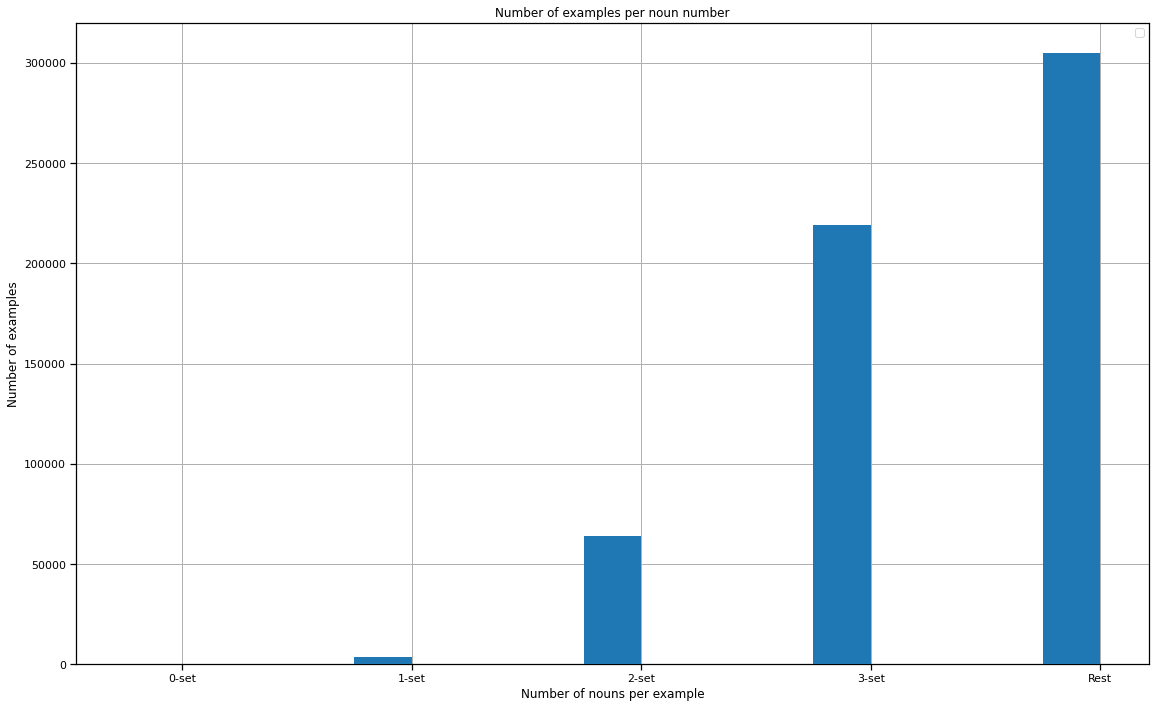

In [15]:
values=[]
for i in range(0,max_noun_no+1):
    values.append(ex_count_per_noun_no[i])
values.append(ex_count_per_noun_no['Rest'])

x_ticklabel = [str(i) + '-set' for i in list(np.arange(max_noun_no+1))] + ['Rest']

plot_bars(values, x_ticklabel, 'Number of nouns per example', 'Number of examples', 
          'Number of examples per noun number')

No handles with labels found to put in legend.


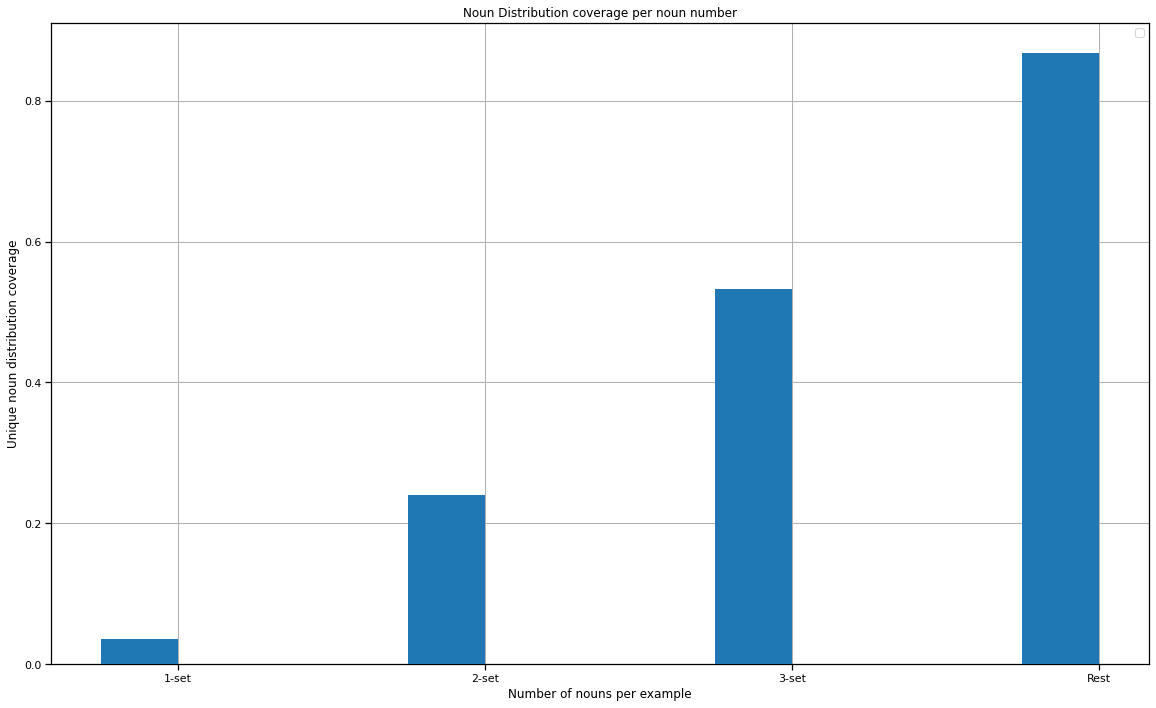

In [16]:
values=[]
for i in range(1,max_noun_no+1):
    values.append(len(noun_distr_per_noun_no[i])/len(net_unique_nouns))
values.append(len(noun_distr_per_noun_no['Rest'])/len(net_unique_nouns))

x_ticklabel = [str(i) + '-set' for i in list(np.arange(1, max_noun_no+1))] + ['Rest']

plot_bars(values, x_ticklabel, 'Number of nouns per example', 'Unique noun distribution coverage', 
          'Noun Distribution coverage per noun number')

### Sets overlap statistics

In [17]:
coco_caps=COCO(ann_file)

loading annotations into memory...
Done (t=1.19s)
creating index...
index created!


In [18]:
caps_per_noun_no = {}

for i, img_cap_ids in enumerate(img_caps_list):
    _, cap_ids = zip(*img_cap_ids)
    caps_per_noun_no[i+1] = coco_caps.loadAnns(list(cap_ids))

In [19]:
prev_overlap_dict = {}

prev_uniq_noun_list=set()
for i in range(2, max_noun_no+2):
    prev_uniq_noun_list.update(set(noun_distr_per_noun_no[i-1]))
    prev_overlap = 0
    new_noun = 0
    for cap_dict in caps_per_noun_no[i]:
        cap = cap_dict['caption']
        tokens = tokenizer.tokenize(cap)
        noun_types_per_ex = set()
        
        found_overlap = 0
        for word, pos in nltk.pos_tag(tokens):
            if 'NN' in pos and word in prev_uniq_noun_list:
                found_overlap += 1
                if found_overlap == i-1:
                    prev_overlap += 1
                    break
                
        if found_overlap < i-1:
            new_noun += 1
        
    prev_overlap_dict[i] = (prev_overlap/len(caps_per_noun_no[i]), new_noun/len(caps_per_noun_no[i]))
    
for noun_no, overlap in prev_overlap_dict.items():
    print(noun_no, overlap)

2 (0.9752768276874542, 0.024723172312545876)
3 (0.9975262888856433, 0.0024737111143566526)
4 (0.9990910612270345, 0.0009089387729654701)


### Separating Objects by phase of introduction 

In [48]:
with open('../datasets/coco/zero-shot/mscoco_unseen_classes.json', 'r') as fin:
    labels_unseen_2 = json.load(fin)

In [52]:
with open('../datasets/coco/zero-shot/mscoco_seen_classes.json', 'r') as fin:
    labels_seen_1 = json.load(fin)

In [53]:
labels_seen_1.remove('background')

In [54]:
lab_phs_unseen_dict={}
for label in labels_unseen:
    if label in noun_distr_per_noun_no[1]:
        lab_phs_unseen_dict[label] = 1
    elif label in noun_distr_per_noun_no[2]:
        lab_phs_unseen_dict[label] = 2
    elif label in noun_distr_per_noun_no[3]:
        lab_phs_unseen_dict[label] = 3       
    elif label in noun_distr_per_noun_no['Rest']:
        lab_phs_unseen_dict[label] = 4              

In [58]:
lab_phs_unseen_dict

{'umbrella': 1,
 'cow': 1,
 'cup': 2,
 'bus': 1,
 'keyboard': 1,
 'skateboard': 1,
 'dog': 1,
 'couch': 1,
 'tie': 1,
 'snowboard': 2,
 'sink': 1,
 'elephant': 1,
 'cake': 1,
 'scissors': 1,
 'airplane': 1,
 'cat': 1,
 'knife': 1}

In [56]:
lab_phs_seen_dict={}
for label in labels_seen:
    if label in noun_distr_per_noun_no[1]:
        lab_phs_seen_dict[label] = 1
    elif label in noun_distr_per_noun_no[2]:
        lab_phs_seen_dict[label] = 2
    elif label in noun_distr_per_noun_no[3]:
        lab_phs_seen_dict[label] = 3       
    elif label in noun_distr_per_noun_no['Rest']:
        lab_phs_seen_dict[label] = 4              

In [57]:
lab_phs_seen_dict

{'toilet': 1,
 'bicycle': 1,
 'apple': 1,
 'train': 1,
 'laptop': 1,
 'carrot': 1,
 'motorcycle': 1,
 'oven': 1,
 'chair': 1,
 'mouse': 2,
 'boat': 1,
 'kite': 1,
 'sheep': 1,
 'horse': 1,
 'sandwich': 1,
 'clock': 1,
 'tv': 1,
 'backpack': 1,
 'toaster': 1,
 'bowl': 1,
 'microwave': 1,
 'bench': 1,
 'book': 1,
 'orange': 1,
 'bird': 1,
 'pizza': 1,
 'fork': 2,
 'frisbee': 1,
 'bear': 1,
 'vase': 1,
 'toothbrush': 1,
 'spoon': 2,
 'giraffe': 1,
 'handbag': 2,
 'broccoli': 1,
 'refrigerator': 1,
 'remote': 1,
 'surfboard': 1,
 'car': 1,
 'bed': 1,
 'banana': 1,
 'donut': 1,
 'skis': 2,
 'person': 1,
 'truck': 1,
 'bottle': 1,
 'suitcase': 1,
 'zebra': 1}

In [41]:
from collections import defaultdict

lab_phs_dict = lab_phs_seen_dict.copy()
lab_phs_dict.update(lab_phs_unseen_dict)
objects_by_phases = defaultdict(list)
for lab, phs in lab_phs_dict.items():
    objects_by_phases[phs].append(lab)
    
objects_by_phases

defaultdict(list,
            {1: ['toilet',
              'bicycle',
              'apple',
              'train',
              'laptop',
              'carrot',
              'motorcycle',
              'oven',
              'chair',
              'boat',
              'kite',
              'sheep',
              'horse',
              'sandwich',
              'clock',
              'tv',
              'backpack',
              'toaster',
              'bowl',
              'microwave',
              'bench',
              'book',
              'orange',
              'bird',
              'pizza',
              'frisbee',
              'bear',
              'vase',
              'toothbrush',
              'giraffe',
              'broccoli',
              'refrigerator',
              'remote',
              'surfboard',
              'car',
              'bed',
              'banana',
              'donut',
              'person',
              'truck',
              'bottle',
 

In [42]:
with open('../../data/coco/coco_stats/objects_by_phases.json', 'w') as f:
    json.dump(objects_by_phases, f)

In [60]:
with open('../datasets/coco/annotations/instances_val2017.json', 'r') as fin:
    coco_val_anno_all = json.load(fin)
labels_all = [item['name'] for item in coco_val_anno_all['categories']]

In [61]:
lab_phs_all_dict={}
for label in labels_all:
    if label in noun_distr_per_noun_no[1]:
        lab_phs_all_dict[label] = 1
    elif label in noun_distr_per_noun_no[2]:
        lab_phs_all_dict[label] = 2
    elif label in noun_distr_per_noun_no[3]:
        lab_phs_all_dict[label] = 3       
    elif label in noun_distr_per_noun_no['Rest']:
        lab_phs_all_dict[label] = 4              

In [62]:
lab_phs_all_dict

{'person': 1,
 'bicycle': 1,
 'car': 1,
 'motorcycle': 1,
 'airplane': 1,
 'bus': 1,
 'train': 1,
 'truck': 1,
 'boat': 1,
 'bench': 1,
 'bird': 1,
 'cat': 1,
 'dog': 1,
 'horse': 1,
 'sheep': 1,
 'cow': 1,
 'elephant': 1,
 'bear': 1,
 'zebra': 1,
 'giraffe': 1,
 'backpack': 1,
 'umbrella': 1,
 'handbag': 2,
 'tie': 1,
 'suitcase': 1,
 'frisbee': 1,
 'skis': 2,
 'snowboard': 2,
 'kite': 1,
 'skateboard': 1,
 'surfboard': 1,
 'bottle': 1,
 'cup': 2,
 'fork': 2,
 'knife': 1,
 'spoon': 2,
 'bowl': 1,
 'banana': 1,
 'apple': 1,
 'sandwich': 1,
 'orange': 1,
 'broccoli': 1,
 'carrot': 1,
 'pizza': 1,
 'donut': 1,
 'cake': 1,
 'chair': 1,
 'couch': 1,
 'bed': 1,
 'toilet': 1,
 'tv': 1,
 'laptop': 1,
 'mouse': 2,
 'remote': 1,
 'keyboard': 1,
 'microwave': 1,
 'oven': 1,
 'toaster': 1,
 'sink': 1,
 'refrigerator': 1,
 'book': 1,
 'clock': 1,
 'vase': 1,
 'scissors': 1,
 'toothbrush': 1}

In [64]:
print(len(labels_all))
print(len(lab_phs_all_dict))

80
65


In [69]:
two_words_labels = set(labels_all) - set(list(lab_phs_all_dict.keys()))
two_words_labels

{'baseball bat',
 'baseball glove',
 'cell phone',
 'dining table',
 'fire hydrant',
 'hair drier',
 'hot dog',
 'parking meter',
 'potted plant',
 'sports ball',
 'stop sign',
 'teddy bear',
 'tennis racket',
 'traffic light',
 'wine glass'}

In [71]:
def get_phase_of_label(label):
    ph = -1
    if label in noun_distr_per_noun_no[1]:
        ph = 1
    elif label in noun_distr_per_noun_no[2]:
        ph = 2
    elif label in noun_distr_per_noun_no[3]:
        ph = 3
    elif label in noun_distr_per_noun_no['Rest']:
        ph = 4
    return ph

for l in two_words_labels:
    l1, l2 = l.split()
    print(f'{l1}: {get_phase_of_label(l1)} \t {l2}: {get_phase_of_label(l2)}')
    

dining: 2 	 table: 1
sports: 1 	 ball: 1
fire: 1 	 hydrant: 2
potted: -1 	 plant: 1
hair: 1 	 drier: 4
hot: 2 	 dog: 1
baseball: 1 	 glove: 2
teddy: 2 	 bear: 1
parking: 2 	 meter: 2
cell: 2 	 phone: 1
wine: 1 	 glass: 1
traffic: 2 	 light: 2
baseball: 1 	 bat: 1
stop: 2 	 sign: 1
tennis: 2 	 racket: 2


### Noun Distribution statistics

No handles with labels found to put in legend.


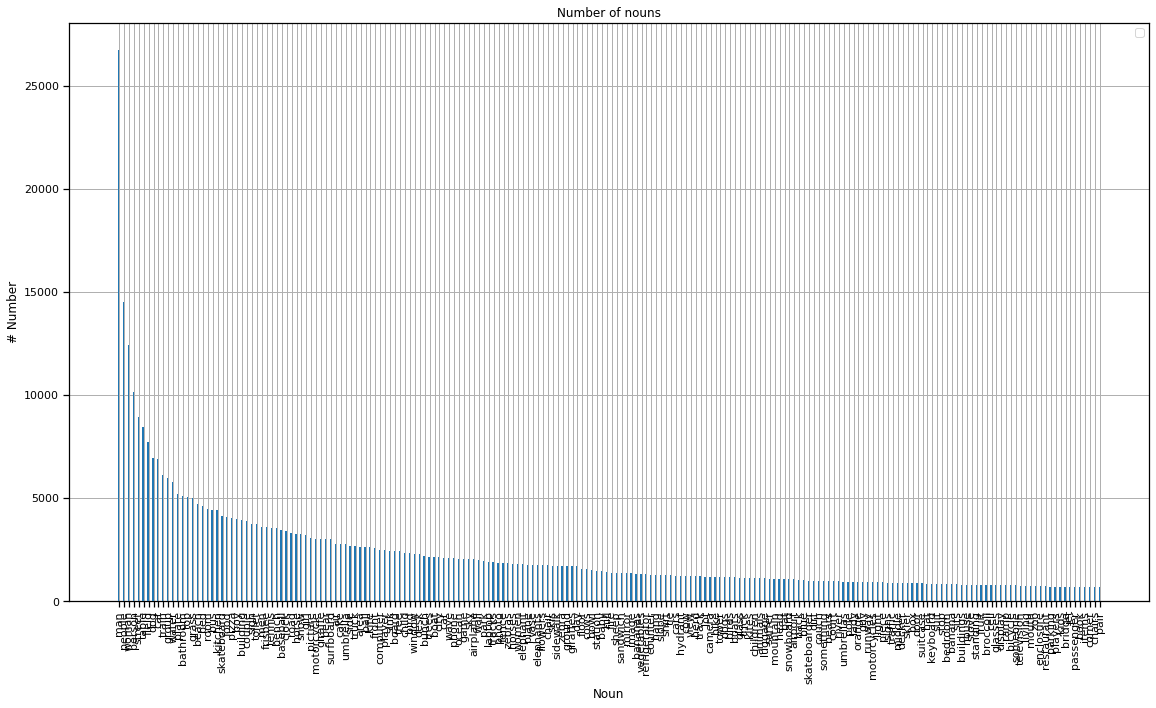

In [24]:
vals = list(noun_distr_per_noun_no[3].values())
keys = list(noun_distr_per_noun_no[3].keys())

sort_idx = list(np.argsort(- np.array(vals)))

x_ticklabel = list(map(keys.__getitem__, sort_idx))[:200]
values = list(map(vals.__getitem__, sort_idx))[:200]

plot_bars(values, x_ticklabel, 'Noun', '# Number', 
          'Number of nouns', rot_angle=90)

In [25]:
values[199]

659

In [26]:
values = sorted(list(vals), reverse=True)
print(len(values))

10003


{1: {bathroom: 1,
  stairs: 1,
  airplane: 1,
  bathroom: 1,
  motorcycles: 1,
  planes: 1,
  kitchen: 1,
  kitchen: 1,
  biplane: 1,
  cats: 1,
  cats: 1,
  bathroom: 1,
  area: 1,
  bathroom: 1,
  motorcycles: 1,
  tree: 1,
  bathroom: 1,
  toilet: 1,
  bathroom: 1,
  bathroom: 1,
  PEOPLE: 1,
  bathroom: 1,
  kitchen: 1,
  bathroom: 1,
  bathroom: 1,
  bathroom: 1,
  kitchen: 1,
  bathroom: 1,
  giraffes: 1,
  bathroom: 1,
  image: 1,
  men: 1,
  people: 1,
  bathroom: 1,
  bathroom: 1,
  bathroom: 1,
  bathroom: 1,
  bathroom: 1,
  kitchen: 1,
  restroom: 1,
  kitchen: 1,
  person: 1,
  airplane: 1,
  bed: 1,
  urinals: 1,
  kitchen: 1,
  toilet: 1,
  toilet: 1,
  kitchen: 1,
  dogs: 1,
  bathroom: 1,
  bathroom: 1,
  airplane: 1,
  Bathroom: 1,
  toothbrush: 1,
  bathroom: 1,
  bathroom: 1,
  kitchen: 1,
  plane: 1,
  salad: 1,
  bowl: 1,
  jet: 1,
  kitchen: 1,
  bathroom: 1,
  toilet: 1,
  motorcycles: 1,
  toilet: 1,
  wall: 1,
  kitchen: 1,
  bathroom: 1,
  bathroom: 1,
  bath

In [27]:
values[2000:2010]

[15, 15, 15, 15, 15, 15, 15, 15, 15, 15]

In [17]:
# with open('../../data/coco/coco_stats/spacy/3_noun/noun_stats.pkl', 'wb') as f:
#     pickle.dump([noun_distr_per_noun_no, ex_count_per_noun_no, net_unique_nouns], f)
# 
# no_nouns_list, img_caps_list = zip(*(sorted(img_caps_per_noun_no.items(), key=lambda l: l[0] if type(l[0])==int else 99999)))
# no_nouns_list, img_caps_list = list(no_nouns_list), list(img_caps_list)
# 
# del(no_nouns_list[0])
# del(img_caps_list[0])
# print(no_nouns_list)
# 
# with open('../../data/coco/coco_stats/spacy/3_noun/img_caps_per_noun_list.pkl', 'wb') as f:
#     pickle.dump(img_caps_list, f)
    
no_nouns_list, img_nouns_list = zip(*(sorted(img_nouns_per_noun_no.items(), key=lambda l: l[0] if type(l[0])==int else 99999)))
no_nouns_list, img_nouns_list = list(no_nouns_list), list(img_nouns_list)

del(no_nouns_list[0])
del(img_nouns_list[0])
print(no_nouns_list)

with open('../../data/coco/coco_stats/spacy/3_noun/img_nouns_per_noun_list.pkl', 'wb') as f:
    pickle.dump(img_nouns_list, f)

[1, 2, 3, 'Rest']


In [58]:
# with open('../../data/coco/coco_stats/spacy/5_noun/noun_stats.pkl', 'wb') as f:
#     pickle.dump([noun_distr_per_noun_no, ex_count_per_noun_no, net_unique_nouns], f)
# 
# no_nouns_list, img_caps_list = zip(*(sorted(img_caps_per_noun_no.items(), key=lambda l: l[0] if type(l[0])==int else 99999)))
# no_nouns_list, img_caps_list = list(no_nouns_list), list(img_caps_list)
# 
# del(no_nouns_list[0])
# del(img_caps_list[0])
# print(no_nouns_list)
# 
# with open('../../data/coco/coco_stats/spacy/5_noun/img_caps_per_noun_list.pkl', 'wb') as f:
#     pickle.dump(img_caps_list, f)

[1, 2, 3, 4, 5, 'Rest']


## Getting Verb Stats

In [ ]:
max_verb_no = 3
# verb_distr_per_verb_no, ex_count_per_verb_no, net_unique_verbs = per_tp_no_distr_stats(max_verb_no, 'VB')

# Loading from saved location
with open('../../data/coco_stats/coco/verb_stats.pkl', 'rb') as f:
    verb_distr_per_verb_no, ex_count_per_verb_no, net_unique_verbs = pickle.load(f)

In [ ]:
max_verb_no = 3
verb_distr_per_verb_no, ex_count_per_verb_no, net_unique_verbs = per_tp_no_distr_stats(max_verb_no, 'VB')

In [ ]:
print('Total Examples with {} verbs per example: {}\n\n'.format(0, ex_count_per_verb_no[0]))

for i in range(1,max_verb_no+1):
    print('Total Examples with {} verbs per example: {}'.
          format(i, ex_count_per_verb_no[i]))
    print('Total Unique verbs with {} verbs per example: {}\n'.format(i, len(verb_distr_per_verb_no[i])))
    
print('Total Examples with > {} verbs per example: {}'.format(max_verb_no, ex_count_per_verb_no['Rest']))
print('Total Unique verbs with > {} verbs per example: {}\n'.format(i, len(verb_distr_per_verb_no['Rest'])))

print('Total number of unique verbs: {}'.format(len(net_unique_verbs)))

## Plotting Verb Stats

In [ ]:
values=[]
for i in range(0,max_verb_no+1):
    values.append(ex_count_per_verb_no[i])
values.append(ex_count_per_verb_no['Rest'])

x_ticklabel = list(np.arange(max_verb_no+1)) + ['Rest']

plot_bars(values, x_ticklabel, 'Number of verbs per example', 'Number of examples', 
          'Number of examples per verb number')

In [ ]:
values=[]
for i in range(1,max_verb_no+1):
    values.append(len(verb_distr_per_verb_no[i])/len(net_unique_verbs))
values.append(len(verb_distr_per_verb_no['Rest'])/len(net_unique_verbs))

x_ticklabel = list(np.arange(1,max_verb_no+1)) + ['Rest']

plot_bars(values, x_ticklabel, 'Number of verbs per example', 'Unique verb distribution coverage', 
          'verb Distribution coverage per verb number')

In [ ]:
# with open('../../data/coco_stats/coco/verb_stats.pkl', 'wb') as f:
#     pickle.dump([verb_distr_per_verb_no, ex_count_per_verb_no, net_unique_verbs], f)

## Getting Noun-Verb statistics

In [ ]:
import itertools

# Counts number of examples for each noun-verb
# for those sentences having number of noun types each of {0,1,2,..max_noun_no,'Rest'}

def per_nv_no_distr_stats(max_noun_no, max_verb_no):
    
    nv_distr_per_nv_no = {}
    ex_count_per_nv_no = {}
    
    for i in list(range(0,max_noun_no+1)) + ['Rest']:
        for j in list(range(0,max_verb_no+1)) + ['Rest']:
            nv_distr_per_nv_no[(i,j)] = {}
            ex_count_per_nv_no[(i,j)] = 0 
        
    net_unique_nvs = set()
    
    def put_words_in_dict(d, ws):
        for w in ws:
            if w not in d:
                d[w] = 1
            else:
                d[w] += 1
    
    for item in coco_train_anno_all['annotations']:
        tokens = tokenizer.tokenize(item['caption'])
        noun_types_per_ex = set()
        verb_types_per_ex = set()
        
        for word, pos in nltk.pos_tag(tokens):
            if 'NN' in pos:
                noun_types_per_ex.add(word)
            elif 'VB' in pos:
                verb_types_per_ex.add(word)               
                
        no_noun_types_per_ex = len(noun_types_per_ex)
        no_verb_types_per_ex = len(verb_types_per_ex)
        no_nv_types_per_ex = (no_noun_types_per_ex, no_verb_types_per_ex)
        if no_noun_types_per_ex > 0 and no_verb_types_per_ex > 0:
            nv_types_per_ex = list(itertools.product(noun_types_per_ex, verb_types_per_ex))
        
        if no_nv_types_per_ex == (0,0):
            ex_count_per_nv_no[(0,0)] += 1
            continue
            
        elif no_noun_types_per_ex == 0:
            idx2 = no_verb_types_per_ex if no_verb_types_per_ex <= max_verb_no else 'Rest'
            d_to_fill = nv_distr_per_nv_no[(0, idx2)]
            v_to_fill = verb_types_per_ex
            ex_count_per_nv_no[(0, idx2)] += 1       
            
        elif no_verb_types_per_ex == 0:
            idx1 = no_noun_types_per_ex if no_noun_types_per_ex <= max_noun_no else 'Rest'
            d_to_fill = nv_distr_per_nv_no[(idx1, 0)]
            v_to_fill = noun_types_per_ex
            ex_count_per_nv_no[(idx1, 0)] += 1                  
            
        elif no_noun_types_per_ex <= max_noun_no and no_verb_types_per_ex <= max_verb_no:
            d_to_fill = nv_distr_per_nv_no[(no_noun_types_per_ex, no_verb_types_per_ex)]
            v_to_fill = nv_types_per_ex
            net_unique_nvs.update(nv_types_per_ex)
            ex_count_per_nv_no[(no_noun_types_per_ex, no_verb_types_per_ex)] += 1
            
        elif no_noun_types_per_ex > max_noun_no and no_verb_types_per_ex > max_verb_no:
            d_to_fill = nv_distr_per_nv_no[('Rest', 'Rest')]
            v_to_fill = nv_types_per_ex
            net_unique_nvs.update(nv_types_per_ex)
            ex_count_per_nv_no[('Rest', 'Rest')] += 1
            
        elif no_noun_types_per_ex > max_noun_no:
            d_to_fill = nv_distr_per_nv_no[('Rest', no_verb_types_per_ex)]
            v_to_fill = nv_types_per_ex
            net_unique_nvs.update(nv_types_per_ex)
            ex_count_per_nv_no[('Rest', no_verb_types_per_ex)] += 1
            
        else:
            d_to_fill = nv_distr_per_nv_no[(no_noun_types_per_ex, 'Rest')]
            v_to_fill = nv_types_per_ex
            net_unique_nvs.update(nv_types_per_ex)
            ex_count_per_nv_no[(no_noun_types_per_ex, 'Rest')] += 1
        
        put_words_in_dict(d_to_fill, v_to_fill)
                
    return nv_distr_per_nv_no, ex_count_per_nv_no, net_unique_nvs

In [ ]:
max_nv_no = 3
# nv_distr_per_nv_no, ex_count_per_nv_no, net_unique_nvs = per_nv_no_distr_stats(max_nv_nv, max_nv_nv)

# Loading from saved location
with open('../../data/coco_stats/coco/noun_verb_stats.pkl', 'rb') as f:
    nv_distr_per_nv_no, ex_count_per_nv_no, net_unique_nvs = pickle.load(f)

## Plotting Noun-Verb Statistics

In [ ]:
values = list(ex_count_per_nv_no.values())
x_ticklabel = list(ex_count_per_nv_no.keys())

x_ticklabel, values = zip(*(sorted(ex_count_per_nv_no.items(), key=lambda l: l[0][1] if type(l[0][1])==int else 99999)))
x_ticklabel, values = list(x_ticklabel), list(values)

plot_bars(values, x_ticklabel, 'Number of noun-verbs per example', 'Number of examples', 
          'Number of examples per noun-verbs statistics', rot_angle=45)

In [ ]:
x_ticklabel = list(nv_distr_per_nv_no.keys())
x_ticklabel.remove((0,0))
values=[]
for el in x_ticklabel:
    if el == (0,0):
        continue
    elif el[0] == 0:
        values.append(0)
#         values.append(len(nv_distr_per_nv_no[el])/len(net_unique_verbs))
    elif el[1] == 0:
        values.append(0)
#         values.append(len(nv_distr_per_nv_no[el])/len(net_unique_nouns))
    else:
        values.append(len(nv_distr_per_nv_no[el])/len(net_unique_nvs))
        
x_ticklabel, values = zip(*(sorted(zip(x_ticklabel, values), key=lambda l: l[0][1] if type(l[0][1])==int else 99999)))
x_ticklabel, values = list(x_ticklabel), list(values)
            
plot_bars(values, x_ticklabel, 'Number of noun-verbs per example', '% Coverage', 
          'Noun-verb Distribution coverage per noun-verb number', rot_angle=45)

In [ ]:
# with open('../../data/coco_stats/coco/noun_verb_stats.pkl', 'wb') as f:
#     pickle.dump([nv_distr_per_nv_no, ex_count_per_nv_no, net_unique_nvs], f)